## 전처리 및 word2vec

In [179]:
import pandas as pd
import numpy as np
from konlpy.tag import Okt
from gensim.models.word2vec import Word2Vec

data = pd.read_excel('comments_result_4.xlsx')
data = data.drop_duplicates('comments', keep = 'first') # 중복 제거
data = data.dropna(axis = 0) # null 값 제거

In [180]:
data.head()

,Unnamed: 0,comments,date
0,0,이번 황금연휴를 보낼 때 개인방역수칙을 지키는 것이 일상으로 돌아가기의 분수령이 될...,2020-04-28T08:58:57
1,1,그러나 마음대로 행동하는 몇몇 사람들 때문에 피로감을 느끼는 사람은 계속 느껴야한다...,2020-04-28T08:58:14
2,2,지금 최소한 저는 마트도 가지않는 생활을 설연휴때부터 시작해서 계속 하고 있습니다....,2020-04-28T09:07:25
3,3,거리두기 피로감 느낄래? 아니면 코로나 폐질환 느낄래?,2020-04-28T08:58:45
4,4,꼭필요하고 지켜야하겠지만....지쳐가는건 사실이다.,2020-04-28T09:03:25


In [181]:
print(len(data))

12949


In [182]:
# 정규 표현식을 통한 한글 외 문자 제거

data['comments'] = data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [183]:
# 불용어 정의

stop_words = []

with open('stopwords.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        stop_words.append(line.rstrip('\n'))

In [184]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 

okt = Okt()
tokenized_data = []
for sentence in data['comments']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
    tokenized_data.append(temp_X)

In [185]:
series_token_data = pd.Series(tokenized_data)
series_token_data[:5]

0    [황금, 연휴, 보내다, 개인, 방역, 수, 칙, 지키다, 일상, 돌아가다, 분수령...
1    [행동, 몇몇, 사람, 때문, 피로, 감, 느끼다, 사람, 계속, 느끼다, 야하다,...
2    [지금, 최소한, 마트, 가지, 않다, 생활, 설연휴, 시작, 계속, 지치다, 그렇...
3           [거리, 두기, 피로, 감, 느끼다, 아니다, 코로나, 폐, 질환, 느끼다]
4                     [꼭, 필요하다, 지키다, 야하다, 지치다, 사실, 이다]
dtype: object

In [186]:
# 토큰 데이터 행 추가

data = data.reset_index(drop=True)
data['comment_token'] = series_token_data
data.tail()

,Unnamed: 0,comments,date,comment_token
12944,321424,정세균총리 개명하시오 냉큼하시오,2020-04-04T13:00:37,"[정세균, 총리, 개명, 냉큼]"
12945,321425,언제까지 거리두기 거리두기 거리두기 거리두기 말만 나불대지말고 그냥 더 강하게 나가...,2020-04-19T15:09:54,"[거리, 두기, 거리, 두기, 거리, 두기, 거리, 두기, 말, 만, 나불대다, 그..."
12946,321426,일베 신천시 대구,2020-04-19T15:18:37,"[일베, 신, 천시, 대구]"
12947,321427,지금 안심할 상황이 아니다 백신 나올때까지 강력한 사회적거리두기 지속하라,2020-04-19T15:11:07,"[지금, 안, 심하다, 상황, 아니다, 백신, 나오다, 강력하다, 사회, 적, 거리..."
12948,321428,아니 찔끔찔끔연장하지말고 나오는 사람 잡아 족치든 빵에 넣든 단기간이라도 강력하게 ...,2020-04-19T15:11:19,"[아니다, 찔끔, 찔끔, 연장, 나오다, 사람, 잡다, 족치다, 빵, 넣다, 단기간..."


## 감정 사전 만들기

In [88]:
six_emodict_df = pd.read_excel("six_emotion_bigram2.xlsx", encoding = 'utf-8')
six_emodict_df.head()

,happy,sad,disgust,angry,surprised,fear
0,가뿐하다,가슴앓이,가소롭다,갈기갈기,갑작스럽다,가혹하다
1,감개무량하다,가엽다,거북하다,개새끼,경악하다,강압적
2,감격스럽다,가엾다,경박하다,개자식,경이,겁쟁이
3,감격하다,가혹하다,괴상하다,격노하다,급작스럽다,공포감
4,감동스럽다,각박하다,괴팍하다,격분하다,기겁하다,공포스럽다


In [89]:
# 감정 별 단어 개수 확인

six_emodict_df.count()

happy        113
sad          174
disgust       77
angry        110
surprised     47
fear          38
dtype: int64

In [94]:
# 감정 리스트에 변수 할당 

six_emotion = six_emodict_df.columns.tolist()
print(six_emotion)
for emo in six_emotion:
    # 단어 사전에서 emo_words 받아오기
    emo_words = six_emodict_df[emo].dropna().tolist() 
    # 단어 토큰화, 토큰화 후 nan값 된 단어 제거
    emo_words = [okt.morphs(x)[0] for x in emo_words if len(okt.morphs(x))>0]
    # 중복 제거
    emo_words = sorted(list(set(emo_words)))
    # 각 감정변수에 차례대로 할당
    globals()[emo] = emo_words
    
angry[:5]

['happy', 'sad', 'disgust', 'angry', 'surprised', 'fear']


['가당찮다', '가증', '갈기갈기', '갈등', '강압']

In [96]:
bi_happy = [('속','시원하다'),('낯','간지럽다'),('정','들다'),('홀','가분')]

bi_sad = [('가슴','아프다'),('기운','없다'),('남','부럽다'),('뒤','숭숭'),('맥','빠지다'),
              ('복','받치다'),('뼈','아프다'),('뼈','저리다'),('애','끓다'),('애','닮다'),
              ('애','타다'),('처','연하다'),('속','썩다'),('속','앓이'),('속','타다')]

bi_disgust =  [('못','밉다'),('정','떨어지다'),('못','마땅하다'),('시','덥다'),('남','부끄럽다'),
                   ('징','그렇다'),('뼈','저리다'),('애','끓다'),('애','닮다'),('처','연하다'),
                   ('속','썩다'),('속','앓이'),('속','타다')]

bi_angry = [('못','되다'),('삐','딱하다'),('비','딱하다'),('약','오르다'),('치','떨리다'),
                ('치밀','오르다'),('성','나다'),('못','마땅하다'),('정','떨어지다'),('남','부끄럽다')]

bi_surprised = [('기상','천외'),('얼','떨다')]

bi_fear = [('뒤','숭숭')]

In [187]:
# 유니그램 만들기

emo_set = [happy, sad, disgust, angry, surprised, fear]
emo_bigram_set = [bi_happy, bi_sad, bi_disgust, bi_angry, bi_surprised, bi_fear]

check_token_lst = []
emo_cnt_lst = []

total_num = len(data)

# comment
for i,comment in enumerate(data['comment_token']):
    print(i/total_num,end="\r")
    check_token = []
    emo_cnt = np.zeros(len(emo_set))
    
    # bigram 처리
    for j, biwords in enumerate(emo_bigram_set):
        for a, b in biwords:
             if (a in comment) & (b in comment):
                check_token.append(a+b)
                emo_cnt[j] += 1 

    # unigram 처리
    for token in comment:
        for k, words in enumerate(emo_set):
            if token in words:
                emo_cnt[k] += 1
                check_token.append(token)

    check_token_lst.append(check_token)
    emo_cnt_lst.append(emo_cnt)

In [188]:
# 비율로 환산

sum_of_emo = np.array(emo_cnt_lst).sum(axis=1,keepdims=True)

emo_ratio = np.array(emo_cnt_lst) / sum_of_emo
emo_ratio[np.isnan(emo_ratio)] = 0

emo_df = pd.DataFrame(emo_ratio,columns = ['happy','sad','disgust','angry','surprised','fear'])

In [189]:
# concat

comment_with_emo = pd.concat([emo_df,
                              data,
                              pd.DataFrame({"check":pd.Series(check_token_lst)})],
                             sort=False,axis=1)

comment_with_emo = comment_with_emo[comment_with_emo['check'].apply(len) > 0]  # 최소 1개의 감정단어 등장한 댓글만 뽑기
del comment_with_emo['Unnamed: 0']  

print(comment_with_emo.shape)
comment_with_emo.head(10)

(3017, 10)


,happy,sad,disgust,angry,surprised,fear,comments,date,comment_token,check
1,0.0,1.0,0.0,0.0,0.0,0.0,그러나 마음대로 행동하는 몇몇 사람들 때문에 피로감을 느끼는 사람은 계속 느껴야한다...,2020-04-28T08:58:14,"[행동, 몇몇, 사람, 때문, 피로, 감, 느끼다, 사람, 계속, 느끼다, 야하다,...",[슬프다]
7,0.0,0.0,0.6,0.4,0.0,0.0,버스에서전화질 수다 마스크미작용 민폐개진상 들 엄청많아요 해이해진분위기 확실하게...,2020-04-28T09:26:36,"[버스, 전, 화질, 수다, 마스크, 밉다, 작용, 민폐, 개, 진상, 들다, 엄청...","[못밉다, 밉다, 밉다, 싫다, 싫다]"
10,1.0,0.0,0.0,0.0,0.0,0.0,대한국민이 최고예요지금 다른나라에선 한달도 못버티고 해수욕장에서 바글바글 모여다니고...,2020-04-28T09:37:53,"[대, 국민, 최고, 지금, 나라, 에선, 달도, 못, 버티고, 해수욕장, 바글바글...",[대]
12,0.0,1.0,0.0,0.0,0.0,0.0,거리두기는 괜챦은데 바이러스가 사라지지않을까 봐 걱정스럽고 우울해지네요,2020-04-28T09:25:48,"[거리, 두기, 괜챦은데, 바이러스, 사라지다, 않다, 보다, 걱정스럽다, 우울하다]","[걱정스럽다, 우울하다]"
16,0.0,0.0,0.0,1.0,0.0,0.0,대한민국 확진자 명 나왔을때 중국의 명절로 인하여 셰게 각국으로 우한페렴 전파가 됄...,2020-04-28T10:04:56,"[대한민국, 확, 진자, 명, 나오다, 중국, 명절, 인하다, 셰, 각국, 우한, ...",[무시]
19,0.0,0.0,0.0,1.0,0.0,0.0,뱍신 나올 때까지 코르나종식은 없구요코르나 이전 생활 이젠 잊으세요그리고 요령껏 ...,2020-04-28T09:12:39,"[뱍신, 나오다, 코르, 종식, 없다, 코르, 이전, 생활, 젠, 잊다, 요령, 껏...",[못되다]
34,0.5,0.5,0.0,0.0,0.0,0.0,월급쟁이들은 내년에 세금과 대보험료 오를 것이나 걱정해라,2020-04-28T13:19:13,"[월급쟁이, 내년, 세금, 대, 보험료, 이나, 걱정]","[대, 걱정]"
44,1.0,0.0,0.0,0.0,0.0,0.0,이미 끝났어 오늘 아울렛 갔었는데 ㅋㅋㅋㅋㅋㅋ 옷 보는것도 아니고 계산대에 자 구부...,2020-04-26T23:12:12,"[이미, 끝나다, 오늘, 아울렛, 가다, ㅋㅋㅋㅋㅋㅋ, 옷, 보다, 아니다, 계산,...",[대]
45,0.0,0.0,0.0,0.0,1.0,0.0,뭐 다 좋다 나도 답답하기는 마찮가지고 그래도 마스크는 제발 꼭 쓰고 다니자 간혹 ...,2020-04-27T03:05:24,"[뭐, 다, 좋다, 나다, 답답하다, 마찮가지, 마스크, 제발, 꼭, 쓰다, 다니다...",[철렁]
47,0.0,1.0,0.0,0.0,0.0,0.0,리조트 이미 지난주초에 다 마감되었던걸 안전에 대한 불안감이 높은나도 사회적거리두기...,2020-04-27T08:33:44,"[리조트, 이미, 지난, 주초, 다, 마감, 되어다, 안전, 대한, 불안감, 높다,...","[우려, 걱정]"


In [190]:
# 엑셀로 저장

comment_with_emo.to_excel('cnn_apr.xlsx')

In [144]:
print("{}개의 댓글 중 {} 개의 댓글이 감정 단어를 보유.".format(len(data),len(comment_with_emo)))

856개의 댓글 중 198 개의 댓글이 감정 단어를 보유.


In [106]:
# 감정 단어 보유 비율에 따라 labeling

from collections import Counter

def label_with_major_emotion(df, ratio):
    over_index = np.where((df.happy > ratio) |
                          (df.sad > ratio) |
                          (df.disgust > ratio) |
                          (df.angry > ratio) |
                          (df.surprised > ratio) |
                          (df.fear > ratio))[0]

    over_df = df.iloc[over_index.tolist(),:]

    # Skipna = True will skip all the Na values 
    # find maximum along column axis 
    over_df['emotion'] = over_df.iloc[:,:6].idxmax(axis = 1, skipna = True)
    print(Counter(over_df.emotion))
    
    return over_df

In [107]:
label_with_major_emotion(comment_with_emo, 0.5).to_pickle("comment_with_emo_over.pkl")

Counter({'disgust': 66, 'sad': 52, 'angry': 38, 'happy': 20, 'fear': 12, 'surprised': 2})


## 시각화

In [44]:
# Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 3, workers = 4, sg = 0)

In [45]:
# 완성된 임베딩 매트릭스의 크기 확인

model.wv.vectors.shape

(1178, 100)

In [54]:
model_name = 'word2vec.model'
model.save(model_name)

In [55]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [67]:
import warnings
 
warnings.filterwarnings("ignore")

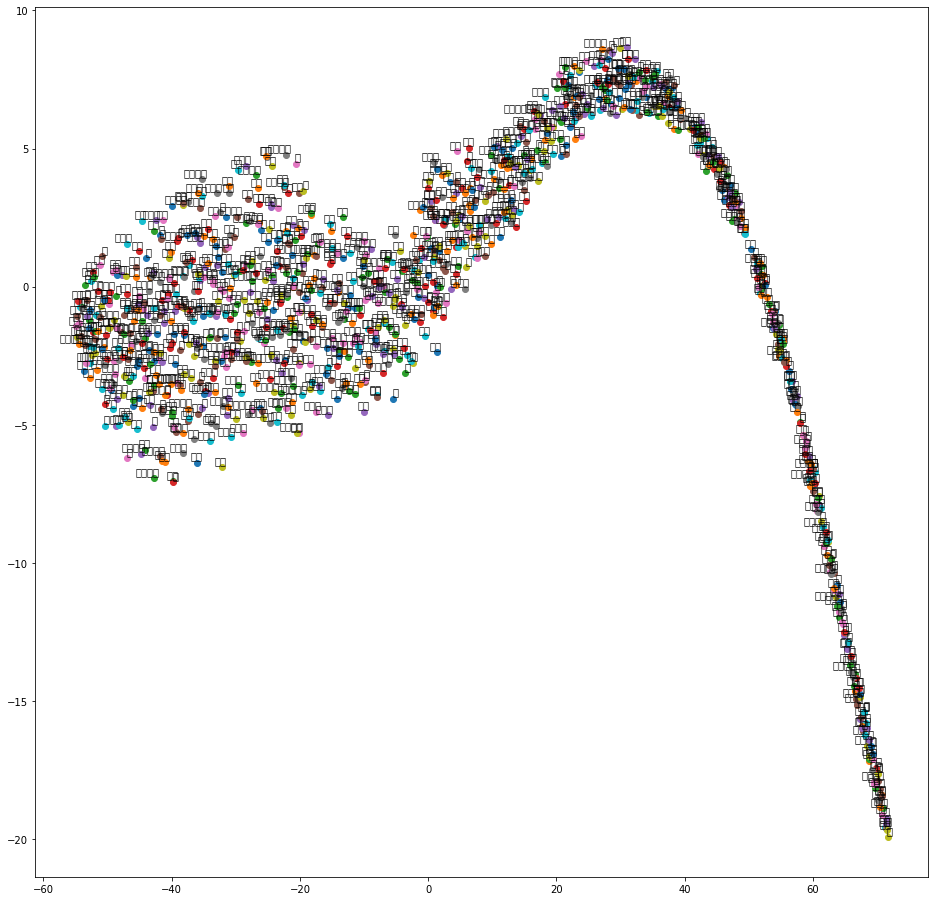

In [73]:
import matplotlib.font_manager as fm
path = 'MALGUN.TTF'
fontprop = fm.FontProperties(fname=path, size=18)
plt.rc('font', family='Malgun')

tsne_plot(model)